# How to infer a complete landscape from experimental data

In contrast to theoretical or toy landscapes, empirical landscapes that are based on experimental data. Such data is noisy and incomplete, so we need to apply additional methods before we have estimates for every genotype of interest to visualize the structure of the genotype-phenotype map.


## Introduction to Variance Component regression

We provide a simple interface to perform Variance Component regression. Briefly, VC regression uses the empirical data to estimate a prior distribution to perform Gaussian Process regression on functions over sequence space characterized by the contribution of the different orders of interaction to the sequence-dependent variability in the data.

A function $f$ can be decomposed into pure $k$th order functions over sequence space for sequences of length $\ell$

$$f = \sum_{k=0}^{\ell} f_k$$

Then, we can estimate and predict the phenotype at every possible sequence assuming that the prior is still valid in regions of sequence space or genotypes that have not been experimentally measured


### Input data

The required input data will be a set of sequences `X` and the associated measurements `y`, and optionally the variance of the measurement `y_var`, if known. Knowning the experimental variance e.g. from replicate experiments, would allow us to tease appart experimental noise from true high order genetic interactions that show complex patterns in the data. 


### Learn more

For more detailed explanations we refer to the original paper

- Zhou, J.; Wong, M. S.; Chen, W.; Krainer, A. R.; Justin, B.; Mccandlish, D. M. Higher-Order Epistasis and Phenotypic Prediction. Proc. Natl. Acad. Sci. USA 2022, 119 (39). [https://doi.org/10.1073/pnas.2204233119](https://doi.org/10.1073/pnas.2204233119).



In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt
import gpmap.src.plot as plot

from os.path import join
from scipy.stats import pearsonr
from gpmap.src.datasets import DataSet
from gpmap.src.inference import VCregression

## Inference from simulated data

We first illustrate how to run VC regression on simulated data from the prior distribution characterized by the variance components $\lambda$'s of each order of interaction. 

### How to sample functions from the prior distribution

A simple way to sample from the prior distribution is by sampling a random uncorrelated function $a$

$$a \sim Normal(0, 1)$$

project it into the different subspaces using the projection operator $W_k$, rescale them to have the associated variance and add them up together

$$f = \sum_{k=0}^{\ell}\lambda_k^{\frac{1}{2}}W_k a$$

We can do it simply as follows, adding some random noise and missing data points for which we can make predictions later

In [2]:
np.random.seed(0)
lambdas_true = np.array([0, 1e3, 2e2, 1e0, 1e-1, 3e-3, 1e-5])

model = VCregression()
model.init(seq_length=6, alphabet_type='dna')
data = model.simulate(lambdas_true, sigma=0.2, p_missing=0.1)
obs = data.dropna()
obs

,y_true,y,y_var
AAAAAA,-0.207772,0.118123,0.04
AAAAAC,-1.686822,-1.706631,0.04
AAAAAT,2.064266,1.774501,0.04
AAAACA,1.263788,0.920955,0.04
AAAACC,0.818644,0.808716,0.04
...,...,...,...
TTTTGG,-1.030013,-0.713674,0.04
TTTTGT,2.345377,2.364254,0.04
TTTTTC,-1.461869,-1.328660,0.04
TTTTTG,-2.741072,-2.634664,0.04


### How to estimate Variance Components $\lambda$'s

This is done through kernel alignment, this is, matching the raw second order matrix with a non-negative linear combination of the covariance matrices $K_k$ associated to each pure $k$ order component 

$$K_{BB} = D_{var} + \sum_k \lambda_k K_k$$

by finding the $\lambda$'s that minimize the Frobenius norm of the difference

$$\min_{\lambda} \lVert yy^T - K_{BB}\lVert_F^2$$




In [3]:
lambdas = model.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)
vc = model.lambdas_to_variance(lambdas)
vc_p = vc / vc.sum() * 100

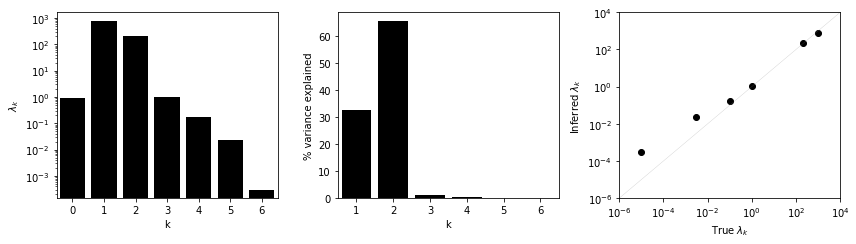

In [4]:
k = np.arange(lambdas.shape[0])

fig, subplots = plt.subplots(1, 3, figsize=(12, 3.5))

axes = subplots[0]
sns.barplot(x=k, y=lambdas, ax=axes, color='black')
axes.set(xlabel='k', ylabel=r'$\lambda_k$', yscale='log')

axes = subplots[1]
sns.barplot(x=k[1:], y=vc_p, ax=axes, color='black')
axes.set(xlabel='k', ylabel='% variance explained')

axes = subplots[2]
axes.scatter(lambdas_true, lambdas, c='black')
lims = (1e-6, 1e4)
axes.plot(lims, lims, c='grey', lw=0.3, alpha=0.5)
axes.set(xscale='log', yscale='log',
         xlabel=r'True $\lambda_k$',
         ylabel=r'Inferred $\lambda_k$',
         xlim=lims, ylim=lims)

fig.tight_layout()

We can see that the inferred variance components are very similar in log scale to the true data-generating parameters. 

However, when data is sparse, kernel alignment is a hard problem and we need to regularize towards simpler solutions. While we could shrink towards additivity, another good general choice that still models high order interactions is towards exponential decay of the variance components. We can do it by setting `cross_validation=True` and penalizing the second order moments of the $\log \lambda_k$ as a function of $k$. It will automatically split the data into different folds and perform kernel alignment under different regularization strength to find the penalization constant that minimizes the Frobenius norm in the validation sets.

In [5]:
cvmodel = VCregression(cross_validation=True)
lambdas = cvmodel.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)

 18%|█████████████████▋                                                                                | 18/100 [00:01<00:07, 11.65it/s]/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/gpmap_tools-0.1.2-py3.7.egg/gpmap/src/kernel.py:248: RuntimeWarning: overflow encountered in exp
  lambdas = np.exp(log_lambdas)
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/gpmap_tools-0.1.2-py3.7.egg/gpmap/src/kernel.py:251: RuntimeWarning: invalid value encountered in double_scalars
  Frob = Frob1 - Frob2
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]


By default, the validation loss is also the Frobenius norm as well, but we can select it to use the $R^2$ on the or the log-likelihood on validation set if we want to take into account the known measurement errors by specifying either `cv_loss_function='r2'` or `cv_loss_function='logL'`.

In [6]:
cvmodel = VCregression(cross_validation=True, cv_loss_function='logL')
lambdas = cvmodel.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


We can visualize the hyperparameter optimization curves during the cross-validation procedure as follows

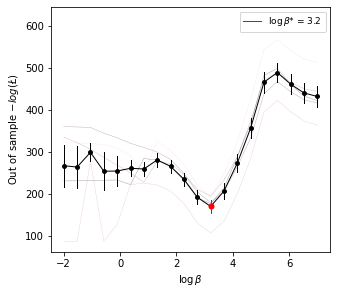

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4.5))
plot.plot_hyperparam_cv(cvmodel.cv_loss_df, axes, x='log_beta', y='loss', show_folds=True,
                        xlabel=r'$\log\beta$', ylabel=r'$-log(\L)$', highlight='min')

### Uniform measurement noise in variance components

We have seen that higher order components are less accurately estimated given their small contribution and the presence of measurement noise. In fact, large uniform measurement noise or, equivalently, a House of Cards (HoC) component will manifest as a constant increase in the variance components that will hinder estimation of high order components even if we exactly know the variance of the measurement error at sequence.

$$K = \sigma^2 I + \sum_k \lambda_k K_k = \sigma^2 \sum_k K_k + \sum_k \lambda_k K_k = \sum_k (\lambda_k + \sigma^2) K_k$$


In [8]:
data2 = model.simulate(lambdas_true, sigma=0.5)
lambdas = model.fit(X=data2.index.values, y=data2.y.values, y_var=data2.y_var.values)

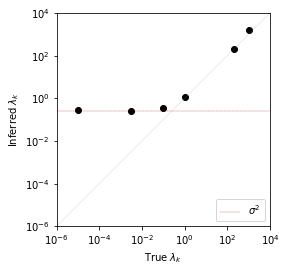

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

axes.scatter(lambdas_true, lambdas, c='black')
lims = (1e-6, 1e4)
axes.plot(lims, lims, c='grey', lw=0.3, alpha=0.5)
axes.plot(lims, (0.25, 0.25), c='darkred', lw=0.3, 
          label=r'$\sigma^2$', linestyle='--')
axes.set(xscale='log', yscale='log',
         xlabel=r'True $\lambda_k$',
         ylabel=r'Inferred $\lambda_k$',
         xlim=lims, ylim=lims,
         aspect=1)
axes.legend(loc=4)

fig.tight_layout()

### How to obtain phenotypic predictions

Once we know the parameters of the Variance Component kernel, this is, the variance components $\lambda_k$, we can directly compute the mean and variance of the posterior distribution of the function for every possible sequence

In [10]:
model.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)
pred = model.predict()
pred

,ypred
AAAAAA,-0.197050
AAAAAC,-1.667246
AAAAAG,-0.525272
AAAAAT,1.877927
AAAACA,0.967353
...,...
TTTTGT,2.400213
TTTTTA,-4.285704
TTTTTC,-1.509820
TTTTTG,-2.761167


We can now compare the predictions with the true function at sequences that were not observed and see how good we can predict missing sequences at random in this regime

In [11]:
test = data.loc[np.isnan(data['y']), :].copy()
test['pred'] = pred.loc[test.index, 'ypred'].values
r2 = pearsonr(test['pred'], test['y_true'])[0] ** 2

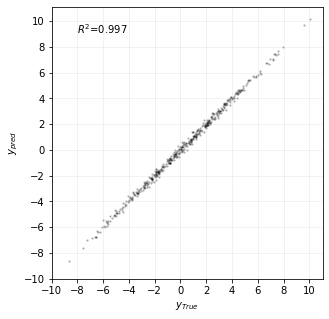

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.scatter(x=test.y_true, y=test.pred, c='black', alpha=0.2, s=2)
ticks = np.arange(-10, 11, 2)
axes.set(xlabel=r'$y_{True}$', ylabel=r'$y_{pred}$', aspect=1,
         xticks=ticks, yticks=ticks)
axes.text(-8, 9, r'$R^2$=' + '{:.3f}'.format(r2))
axes.grid(alpha=0.2)

### How to calculate uncertainty of the predictions

In the previous section, we have shown how to obtain the best estimates for unobserved sequences given the data and the estimated variance components. However, in cases where the ground truth is not known, it can be useful to have an idea about the uncertainty of the phenotypic predictions for new sequences. As we are using Gaussian Process models with Gaussian likelihood function, we can compute, not only the posterior mean, but also the posterior variance and derive the 95% probability predictive interval for these sequences by setting `calc_variance=True`.



In [13]:
xpred = np.random.choice(test.index.values, 100)
pred = model.predict(xpred, calc_variance=True)
pred['y_true'] = data.loc[pred.index.values, 'y_true']
pred['sd'] = np.sqrt(pred['var'])
pred['lower'] = pred['ypred'] - 2* pred['sd']
pred['upper'] = pred['ypred'] + 2* pred['sd']
pred

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.57it/s]


,ypred,var,y_true,sd,lower,upper
GCTCTA,0.190808,0.053735,0.097427,0.231809,-0.272810,0.654425
TACCAA,1.977900,0.047620,2.090013,0.218221,1.541458,2.414341
CTCTCG,-2.894538,0.049928,-2.830052,0.223446,-3.341430,-2.447645
GTGAAA,-2.532334,0.052653,-2.748958,0.229461,-2.991257,-2.073411
GGCTGC,3.638155,0.050029,3.383262,0.223672,3.190811,4.085499
...,...,...,...,...,...,...
ATTAAA,0.352650,0.052678,0.427717,0.229518,-0.106386,0.811686
AAGTAC,0.991078,0.049963,1.190414,0.223524,0.544031,1.438126
CTCCCT,-2.543910,0.050045,-2.276967,0.223707,-2.991325,-2.096496
CATCGA,5.925633,0.050166,6.283029,0.223979,5.477676,6.373590


We can now check that predictions are well calibrated, this is, that the true value lies withing the 95% probability predicted interval close to the expected 95% probability; and show the error bars in the scatterplot to visualize if uncertainty is uniformly distributed along the whole range of true phenotypic values.

Text(-6, 10.5, 'Calibration=99.0%')

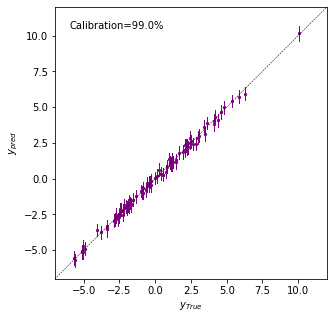

In [14]:
perc = np.mean((pred['y_true'] > pred['lower']) & (pred['y_true'] < pred['upper'])) * 100
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(x=pred.y_true, y=pred.ypred, c='purple', s=5)
for x, l, u in zip(pred['y_true'], pred['lower'], pred['upper']):
    axes.plot((x, x), (l, u), lw=1, c='purple')
lim = (-7, 12)
axes.plot(lim, lim, lw=0.5, c='black', linestyle='--')
axes.set(xlabel=r'$y_{True}$', ylabel=r'$y_{pred}$', aspect=1,
         ylim=lim, xlim=lim)
axes.text(-6, 10.5, 'Calibration={}%'.format(perc))

## Inference from real data: GB1 landscape

In the next section, we are going to infer the complete combinatorial landscape of the protein G domain B1 from experimental data ([Wu et. al (2016)](https://elifesciences.org/articles/16965)). In this study, a library containing nearly all possible aminoacid combinations at positions 39, 40, 41 and 54 was selected for binding to the constant fraction of IgG using an mRNA display approach. Thus, by sequencing the mRNA library before and after selection, we can obtain estimates of how strongly each sequence in the library binds its target. 

### Data preprocessing

We take the number of times a sequence is observed in the input and selected samples as raw data for our purposes as provided by the authors [here](https://elifesciences.org/articles/16965/figures#SD1-data). We use [Enrich2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1272-5) approach to derive the enrichment score and the associated error. 

$$y_i = log\left(\frac{ c_{i,sel} + 0.5}{c_{wt,sel} + 0.5} \right) - log\left(\frac{ c_{i,inp} + 0.5}{c_{wt,inp} + 0.5} \right)$$


$$y_{var,i} = \frac{1}{c_{i,inp} + 0.5} + \frac{1}{c_{wt,inp} + 0.5} + \frac{1}{c_{i,sel} + 0.5} +\frac{1}{c_{wt,sel} + 0.5}$$


In [15]:
gb1 = DataSet('gb1')
counts = gb1.raw_data
counts

,input,selected
sequence,,
VDGV,92735,338346
ADGV,34,43
CDGV,850,641
DDGV,63,63
EDGV,841,190
...,...,...
YYYR,203,1
YYYS,186,3
YYYT,181,14


In [16]:
wt = 'VDGV'
c_wt_input, c_wt_sel = counts.loc[wt]
X = counts.index.values
y = (np.log((counts['selected'] + 0.5)/(c_wt_sel + 0.5)) - np.log((counts['input'] + 0.5)/(c_wt_input + 0.5))).values
y_var = (1/(counts['input'] + 0.5) + 1/(counts['selected'] + 0.5) + 1/(c_wt_sel + 0.5) + 1/(c_wt_input + 0.5)).values
data = pd.DataFrame({'y': y, 'y_var': y_var}, index=X)

### Estimating Variance Components

To be able to evaluate model performance, we first split the data into training and test sets keeping approximately 90% of the data for training and 10% for testing

In [17]:
u = np.random.uniform(size=y.shape[0]) < 0.9
X_train, y_train, y_var_train = X[u], y[u], y_var[u]
X_test, y_test = X[~u], y[~u]

In [18]:
model = VCregression(cross_validation=True, cv_loss_function='logL')
lambdas = model.fit(X=X_train, y=y_train, y_var=y_var_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


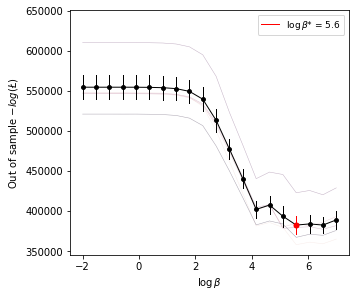

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4.5))
plot.plot_hyperparam_cv(model.cv_loss_df, axes, x='log_beta', y='loss', show_folds=True,
                        xlabel=r'$\log\beta$', ylabel=r'$-log(\L)$', highlight='min')

In [20]:
x = np.arange(0, lambdas.shape[0])
variance = model.lambdas_to_variance(lambdas)
p_variance = variance / variance.sum() * 100

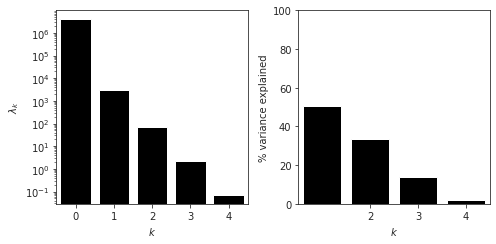

In [21]:
fig, subplots = plot.init_fig(1, 2, colsize=3.5, rowsize=3.5)

axes = subplots[0]
sns.barplot(x=x, y=lambdas, ax=axes, color='black')
axes.set(xlabel='$k$', ylabel='$\lambda_k$', yscale='log')

axes = subplots[1]
sns.barplot(x=x[1:], y=p_variance, ax=axes, color='black')
axes.set(xlabel='$k$', ylabel='% variance explained', ylim=(0, 100), xticks=[1, 2, 3])

fig.tight_layout()

### Inferring the complete GB1 landscape

Now that we have inferred the variance components, we obtain inferences for the complete combinatorial landscape and check the prediction accuracy for the held-out test data. Moreover, we can also see the distribution of phenotypic values within and outside the data

In [22]:
pred = model.predict().join(data)
pred

,ypred,y,y_var
AAAA,-0.148634,0.460831,0.046009
AAAC,-3.077732,NaN,NaN
AAAD,-3.265338,NaN,NaN
AAAE,-3.884423,NaN,NaN
AAAF,-2.900805,NaN,NaN
...,...,...,...
YYYS,-4.656507,-5.269987,0.291090
YYYT,-3.055573,-3.821426,0.074489
YYYV,-3.237321,-3.143536,0.074682
YYYW,-5.199626,-4.306581,0.699467


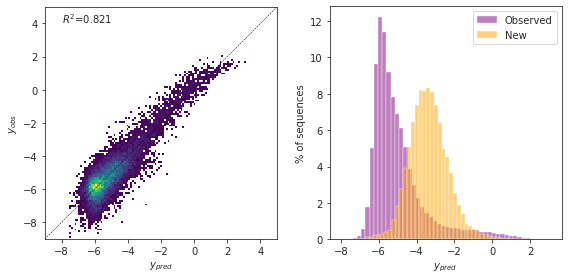

In [23]:
test = pred.loc[X_test, :]
r2 = pearsonr(test['ypred'], test['y'])[0] ** 2

fig, subplots = plt.subplots(1, 2, figsize=(8, 4))

axes = subplots[0]
lim = (-9, 5)
sns.histplot(x=test['ypred'], y=test['y'], cmap='viridis', ax=axes)
axes.plot(lim, lim, lw=0.5, linestyle='--', c='black')
axes.set(xlabel=r'$y_{pred}$', ylabel=r'$y_{obs}$',
         xlim=lim, ylim=lim, aspect=1)
axes.text(-8, 4, r'$R^2$=' + '{:.3f}'.format(r2))

axes = subplots[1]
sns.histplot(pred.dropna()['ypred'], ax=axes, label='Observed',
             alpha=0.5, stat='percent', bins=50, color='purple')
sns.histplot(pred.loc[np.isnan(pred['y']), 'ypred'], ax=axes, label='New',
             alpha=0.5, stat='percent', bins=50, color='orange')
axes.legend(loc=0)
axes.set(xlabel=r'$y_{pred}$', ylabel='% of sequences')

fig.tight_layout()